# spotify api permission call 

# function： Generate the top 20 genres

In [43]:
import base64
from requests import post, get
import json

# App ID secret
client_id = "ea30f245dd2d46e7bf46d970ead88096"
client_secret = "70dd9a46ee804e308009d613036476a5"

# request an order
def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
        
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

# Get Title
def get_auth_header(token):
    return {"Authorization": "Bearer " + token}


# Deriving the top 20 song styles in the U.S. region
def get_genres(access_token, country='US', limit=20, offset=0):
    # According to the url provided by the API
    genres_url = "https://api.spotify.com/v1/browse/categories"
    # request header
    headers = get_auth_header(access_token)
    # Request Parameters
    params = {
        "country": country,
        "limit": limit,
        'offset': offset
    }
    # Getting data
    response = get(genres_url, headers=headers, params=params)
    genres_data = response.json()
    genres = [(category['id'], category['name']) for category in genres_data['categories']['items']]

    return genres

# Initializing the Style Array
genres = []
token = get_token()

# Getting genres data
result = get_genres(token)

for genre_id, genre in result:
    genres.append(f'genre:"{genre}"')

print(genres)


['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']


# Getting a token

In [31]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
# Get Access
client_id = "ea30f245dd2d46e7bf46d970ead88096"
client_secret = "70dd9a46ee804e308009d613036476a5"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = get_token()


# Get 50 songs in each of the top 20 genres

In [44]:
import pandas as pd
import time

# Calculate the top 50 songs for each song style
def creat_frame(quert_list, limit):
    # Initializing the database
    data = {
        'Track ID': [],
        'Track name': [],
        'Artist': [],
        'Popularity': [],
        'Release year': [],
        'Genres': []
    }
    # Iterative genres
    for query in quert_list:
        search_result = sp.search(query, limit=limit, type='track')
        tracks = search_result['tracks']['items']

        for track in tracks:
            data['Track ID'].append(track['id'])
            data['Track name'].append(track['name'])
            data['Artist'].append(track['artists'][0]['name'])
            data['Popularity'].append(track['popularity'])
            data['Release year'].append(track['album']['release_date'][:4])
            data['Genres'].append(query)
            

    df = pd.DataFrame(data)
    return df

genres = ['genre:"Top Lists"', 'genre:"Hip-Hop"', 'genre:"Pop"', 'genre:"Country"', 'genre:"Latin"', 'genre:"Rock"', 'genre:"Summer"', 'genre:"Workout"', 'genre:"R&B"', 'genre:"Dance/Electronic"', 'genre:"Netflix"', 'genre:"Indie"', 'genre:"Mood"', 'genre:"Sleep"', 'genre:"Christian & Gospel"', 'genre:"Regional Mexican"', 'genre:"Wellness"', 'genre:"Chill"', 'genre:"EQUAL"', 'genre:"Gaming"']
df = creat_frame(genres, limit=50)
df

,Track ID,Track name,Artist,Popularity,Release year,Genres
0,7hsoPHAKaHzstyW5cb5dNh,Vultures,B.o.B,17,2016,"genre:""Hip-Hop"""
1,28TRqVhkXl9ABFktGlf6fc,Mind Gamez (feat. B-Dawg & Icee),Big Tone,10,2018,"genre:""Hip-Hop"""
2,4BWIoFaTx1d5rjXyL33lOD,Sabr,Mandou,7,2022,"genre:""Hip-Hop"""
3,46tByC4fzqmvhIPu32ySyc,When You Need Me,Apathy,15,2015,"genre:""Hip-Hop"""
4,7eeSJCKo8bz7o8gxFiiNGQ,When They Hate,Grind Mode,5,2023,"genre:""Hip-Hop"""
...,...,...,...,...,...,...
745,1B6glo44ZBnK6zHPnNQHti,Locked N' Loaded,Benda,5,2019,"genre:""Gaming"""
746,58ROyhzxq8Frn5Txo8IwXY,Antihuman,Jiqui,3,2019,"genre:""Gaming"""
747,5NIfOO7Jf1F7xSZu3NEl3t,Slow,Aweminus,5,2023,"genre:""Gaming"""
748,3wosjWP9C7lqnD2pDDVjOO,Chain Protocol,Stabby,3,2018,"genre:""Gaming"""


# Spectrum analysis of each song acquired

In [7]:
import time
# Getting audio features
def get_audio_features(track_id, access_token):
    audio_features_url = f'https://api.spotify.com/v1/audio-features/{track_id}'
    response = get(audio_features_url, headers=get_auth_header(token))
    
    # Avoid speed limits
    time.sleep(0.1)
    
    # Avoid frequent visits
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get audio feature. Status Code: {response.status_code}.")
    return None

In [8]:
# Retrieve Track ID
track_ids = df['Track ID'].tolist()
audio_features = []
for i in track_ids:
    audio_features.append(get_audio_features(i, token))
#     print(audio_features)

In [9]:
audio_features_df = pd.DataFrame(audio_features)

In [10]:
audio_features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.658,0.721,9,-6.229,1,0.0951,0.03600,0.000000,0.0828,0.121,100.071,audio_features,7hsoPHAKaHzstyW5cb5dNh,spotify:track:7hsoPHAKaHzstyW5cb5dNh,https://api.spotify.com/v1/tracks/7hsoPHAKaHzs...,https://api.spotify.com/v1/audio-analysis/7hso...,151667,5
1,0.811,0.662,1,-8.846,0,0.1820,0.71100,0.000000,0.2630,0.555,97.510,audio_features,5aonpFlPRTroHzB8gX9ytv,spotify:track:5aonpFlPRTroHzB8gX9ytv,https://api.spotify.com/v1/tracks/5aonpFlPRTro...,https://api.spotify.com/v1/audio-analysis/5aon...,142507,4
2,0.826,0.801,4,-5.602,1,0.1320,0.40100,0.000000,0.3490,0.757,90.003,audio_features,28TRqVhkXl9ABFktGlf6fc,spotify:track:28TRqVhkXl9ABFktGlf6fc,https://api.spotify.com/v1/tracks/28TRqVhkXl9A...,https://api.spotify.com/v1/audio-analysis/28TR...,236504,4
3,0.798,0.420,0,-11.651,1,0.3460,0.10700,0.000000,0.1120,0.704,125.922,audio_features,6PsxJfg2gjwP6VhC41nivY,spotify:track:6PsxJfg2gjwP6VhC41nivY,https://api.spotify.com/v1/tracks/6PsxJfg2gjwP...,https://api.spotify.com/v1/audio-analysis/6Psx...,108827,4
4,0.861,0.557,1,-7.812,1,0.2540,0.06500,0.000072,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.496,0.994,2,-1.588,1,0.4200,0.00916,0.611000,0.0684,0.266,149.772,audio_features,1B6glo44ZBnK6zHPnNQHti,spotify:track:1B6glo44ZBnK6zHPnNQHti,https://api.spotify.com/v1/tracks/1B6glo44ZBnK...,https://api.spotify.com/v1/audio-analysis/1B6g...,169600,4
746,0.590,0.990,1,-1.789,1,0.3640,0.00207,0.165000,0.2530,0.344,150.016,audio_features,58ROyhzxq8Frn5Txo8IwXY,spotify:track:58ROyhzxq8Frn5Txo8IwXY,https://api.spotify.com/v1/tracks/58ROyhzxq8Fr...,https://api.spotify.com/v1/audio-analysis/58RO...,231600,4
747,0.776,0.836,1,-1.592,1,0.0404,0.00201,0.000000,0.3580,0.279,141.967,audio_features,5NIfOO7Jf1F7xSZu3NEl3t,spotify:track:5NIfOO7Jf1F7xSZu3NEl3t,https://api.spotify.com/v1/tracks/5NIfOO7Jf1F7...,https://api.spotify.com/v1/audio-analysis/5NIf...,273074,4
748,0.704,0.943,9,-0.630,1,0.3680,0.07950,0.090700,0.1030,0.163,150.054,audio_features,3wosjWP9C7lqnD2pDDVjOO,spotify:track:3wosjWP9C7lqnD2pDDVjOO,https://api.spotify.com/v1/tracks/3wosjWP9C7lq...,https://api.spotify.com/v1/audio-analysis/3wos...,230400,4


# Data cleansing, Merging, De-duplication. Removal of interfering terms

In [11]:
# Merge the two tables, with the original table on the left
merged_df = df.merge(audio_features_df, left_on='Track ID', right_on='id', how='inner')
merged_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,7hsoPHAKaHzstyW5cb5dNh,Vultures,B.o.B,17,2016,"genre:""Hip-Hop""",0.658,0.721,9,-6.229,...,0.0828,0.121,100.071,audio_features,7hsoPHAKaHzstyW5cb5dNh,spotify:track:7hsoPHAKaHzstyW5cb5dNh,https://api.spotify.com/v1/tracks/7hsoPHAKaHzs...,https://api.spotify.com/v1/audio-analysis/7hso...,151667,5
1,5aonpFlPRTroHzB8gX9ytv,Low Rider,Big Rome,11,2020,"genre:""Hip-Hop""",0.811,0.662,1,-8.846,...,0.2630,0.555,97.510,audio_features,5aonpFlPRTroHzB8gX9ytv,spotify:track:5aonpFlPRTroHzB8gX9ytv,https://api.spotify.com/v1/tracks/5aonpFlPRTro...,https://api.spotify.com/v1/audio-analysis/5aon...,142507,4
2,28TRqVhkXl9ABFktGlf6fc,Mind Gamez (feat. B-Dawg & Icee),Big Tone,10,2018,"genre:""Hip-Hop""",0.826,0.801,4,-5.602,...,0.3490,0.757,90.003,audio_features,28TRqVhkXl9ABFktGlf6fc,spotify:track:28TRqVhkXl9ABFktGlf6fc,https://api.spotify.com/v1/tracks/28TRqVhkXl9A...,https://api.spotify.com/v1/audio-analysis/28TR...,236504,4
3,6PsxJfg2gjwP6VhC41nivY,פרסים,Shay TRA Litman,17,2021,"genre:""Hip-Hop""",0.798,0.420,0,-11.651,...,0.1120,0.704,125.922,audio_features,6PsxJfg2gjwP6VhC41nivY,spotify:track:6PsxJfg2gjwP6VhC41nivY,https://api.spotify.com/v1/tracks/6PsxJfg2gjwP...,https://api.spotify.com/v1/audio-analysis/6Psx...,108827,4
4,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,...,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1B6glo44ZBnK6zHPnNQHti,Locked N' Loaded,Benda,5,2019,"genre:""Gaming""",0.496,0.994,2,-1.588,...,0.0684,0.266,149.772,audio_features,1B6glo44ZBnK6zHPnNQHti,spotify:track:1B6glo44ZBnK6zHPnNQHti,https://api.spotify.com/v1/tracks/1B6glo44ZBnK...,https://api.spotify.com/v1/audio-analysis/1B6g...,169600,4
754,58ROyhzxq8Frn5Txo8IwXY,Antihuman,Jiqui,3,2019,"genre:""Gaming""",0.590,0.990,1,-1.789,...,0.2530,0.344,150.016,audio_features,58ROyhzxq8Frn5Txo8IwXY,spotify:track:58ROyhzxq8Frn5Txo8IwXY,https://api.spotify.com/v1/tracks/58ROyhzxq8Fr...,https://api.spotify.com/v1/audio-analysis/58RO...,231600,4
755,5NIfOO7Jf1F7xSZu3NEl3t,Slow,Aweminus,5,2023,"genre:""Gaming""",0.776,0.836,1,-1.592,...,0.3580,0.279,141.967,audio_features,5NIfOO7Jf1F7xSZu3NEl3t,spotify:track:5NIfOO7Jf1F7xSZu3NEl3t,https://api.spotify.com/v1/tracks/5NIfOO7Jf1F7...,https://api.spotify.com/v1/audio-analysis/5NIf...,273074,4
756,3wosjWP9C7lqnD2pDDVjOO,Chain Protocol,Stabby,3,2018,"genre:""Gaming""",0.704,0.943,9,-0.630,...,0.1030,0.163,150.054,audio_features,3wosjWP9C7lqnD2pDDVjOO,spotify:track:3wosjWP9C7lqnD2pDDVjOO,https://api.spotify.com/v1/tracks/3wosjWP9C7lq...,https://api.spotify.com/v1/audio-analysis/3wos...,230400,4


In [12]:
# 去重处理
uni_df = merged_df.drop_duplicates(subset='Track ID', keep='first')

In [13]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,7hsoPHAKaHzstyW5cb5dNh,Vultures,B.o.B,17,2016,"genre:""Hip-Hop""",0.658,0.721,9,-6.229,...,0.0828,0.121,100.071,audio_features,7hsoPHAKaHzstyW5cb5dNh,spotify:track:7hsoPHAKaHzstyW5cb5dNh,https://api.spotify.com/v1/tracks/7hsoPHAKaHzs...,https://api.spotify.com/v1/audio-analysis/7hso...,151667,5
1,5aonpFlPRTroHzB8gX9ytv,Low Rider,Big Rome,11,2020,"genre:""Hip-Hop""",0.811,0.662,1,-8.846,...,0.2630,0.555,97.510,audio_features,5aonpFlPRTroHzB8gX9ytv,spotify:track:5aonpFlPRTroHzB8gX9ytv,https://api.spotify.com/v1/tracks/5aonpFlPRTro...,https://api.spotify.com/v1/audio-analysis/5aon...,142507,4
2,28TRqVhkXl9ABFktGlf6fc,Mind Gamez (feat. B-Dawg & Icee),Big Tone,10,2018,"genre:""Hip-Hop""",0.826,0.801,4,-5.602,...,0.3490,0.757,90.003,audio_features,28TRqVhkXl9ABFktGlf6fc,spotify:track:28TRqVhkXl9ABFktGlf6fc,https://api.spotify.com/v1/tracks/28TRqVhkXl9A...,https://api.spotify.com/v1/audio-analysis/28TR...,236504,4
3,6PsxJfg2gjwP6VhC41nivY,פרסים,Shay TRA Litman,17,2021,"genre:""Hip-Hop""",0.798,0.420,0,-11.651,...,0.1120,0.704,125.922,audio_features,6PsxJfg2gjwP6VhC41nivY,spotify:track:6PsxJfg2gjwP6VhC41nivY,https://api.spotify.com/v1/tracks/6PsxJfg2gjwP...,https://api.spotify.com/v1/audio-analysis/6Psx...,108827,4
4,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,...,0.1710,0.710,85.472,audio_features,3e5cQVJ9koKY7Rqz0aCP5j,spotify:track:3e5cQVJ9koKY7Rqz0aCP5j,https://api.spotify.com/v1/tracks/3e5cQVJ9koKY...,https://api.spotify.com/v1/audio-analysis/3e5c...,124280,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1B6glo44ZBnK6zHPnNQHti,Locked N' Loaded,Benda,5,2019,"genre:""Gaming""",0.496,0.994,2,-1.588,...,0.0684,0.266,149.772,audio_features,1B6glo44ZBnK6zHPnNQHti,spotify:track:1B6glo44ZBnK6zHPnNQHti,https://api.spotify.com/v1/tracks/1B6glo44ZBnK...,https://api.spotify.com/v1/audio-analysis/1B6g...,169600,4
754,58ROyhzxq8Frn5Txo8IwXY,Antihuman,Jiqui,3,2019,"genre:""Gaming""",0.590,0.990,1,-1.789,...,0.2530,0.344,150.016,audio_features,58ROyhzxq8Frn5Txo8IwXY,spotify:track:58ROyhzxq8Frn5Txo8IwXY,https://api.spotify.com/v1/tracks/58ROyhzxq8Fr...,https://api.spotify.com/v1/audio-analysis/58RO...,231600,4
755,5NIfOO7Jf1F7xSZu3NEl3t,Slow,Aweminus,5,2023,"genre:""Gaming""",0.776,0.836,1,-1.592,...,0.3580,0.279,141.967,audio_features,5NIfOO7Jf1F7xSZu3NEl3t,spotify:track:5NIfOO7Jf1F7xSZu3NEl3t,https://api.spotify.com/v1/tracks/5NIfOO7Jf1F7...,https://api.spotify.com/v1/audio-analysis/5NIf...,273074,4
756,3wosjWP9C7lqnD2pDDVjOO,Chain Protocol,Stabby,3,2018,"genre:""Gaming""",0.704,0.943,9,-0.630,...,0.1030,0.163,150.054,audio_features,3wosjWP9C7lqnD2pDDVjOO,spotify:track:3wosjWP9C7lqnD2pDDVjOO,https://api.spotify.com/v1/tracks/3wosjWP9C7lq...,https://api.spotify.com/v1/audio-analysis/3wos...,230400,4


In [14]:
# Removing useless data
drop_need = ['id', 'uri', 'track_href', 'analysis_url', 'type']
uni_df = uni_df.drop(columns=drop_need, axis=1)

In [15]:
# Renumbering of data
uni_df.reset_index(drop=True, inplace=True)


In [16]:
uni_df

,Track ID,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7hsoPHAKaHzstyW5cb5dNh,Vultures,B.o.B,17,2016,"genre:""Hip-Hop""",0.658,0.721,9,-6.229,1,0.0951,0.03600,0.000000,0.0828,0.121,100.071,151667,5
1,5aonpFlPRTroHzB8gX9ytv,Low Rider,Big Rome,11,2020,"genre:""Hip-Hop""",0.811,0.662,1,-8.846,0,0.1820,0.71100,0.000000,0.2630,0.555,97.510,142507,4
2,28TRqVhkXl9ABFktGlf6fc,Mind Gamez (feat. B-Dawg & Icee),Big Tone,10,2018,"genre:""Hip-Hop""",0.826,0.801,4,-5.602,1,0.1320,0.40100,0.000000,0.3490,0.757,90.003,236504,4
3,6PsxJfg2gjwP6VhC41nivY,פרסים,Shay TRA Litman,17,2021,"genre:""Hip-Hop""",0.798,0.420,0,-11.651,1,0.3460,0.10700,0.000000,0.1120,0.704,125.922,108827,4
4,3e5cQVJ9koKY7Rqz0aCP5j,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,1,0.2540,0.06500,0.000072,0.1710,0.710,85.472,124280,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,1B6glo44ZBnK6zHPnNQHti,Locked N' Loaded,Benda,5,2019,"genre:""Gaming""",0.496,0.994,2,-1.588,1,0.4200,0.00916,0.611000,0.0684,0.266,149.772,169600,4
742,58ROyhzxq8Frn5Txo8IwXY,Antihuman,Jiqui,3,2019,"genre:""Gaming""",0.590,0.990,1,-1.789,1,0.3640,0.00207,0.165000,0.2530,0.344,150.016,231600,4
743,5NIfOO7Jf1F7xSZu3NEl3t,Slow,Aweminus,5,2023,"genre:""Gaming""",0.776,0.836,1,-1.592,1,0.0404,0.00201,0.000000,0.3580,0.279,141.967,273074,4
744,3wosjWP9C7lqnD2pDDVjOO,Chain Protocol,Stabby,3,2018,"genre:""Gaming""",0.704,0.943,9,-0.630,1,0.3680,0.07950,0.090700,0.1030,0.163,150.054,230400,4


In [22]:
drop_columns = ['Track ID', 'duration_ms', 'time_signature']
# Remove irrelevant columns
final_df = uni_df.drop(columns=drop_columns)
final_df

,Track name,Artist,Popularity,Release year,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Vultures,B.o.B,17,2016,"genre:""Hip-Hop""",0.658,0.721,9,-6.229,1,0.0951,0.03600,0.000000,0.0828,0.121,100.071
1,Low Rider,Big Rome,11,2020,"genre:""Hip-Hop""",0.811,0.662,1,-8.846,0,0.1820,0.71100,0.000000,0.2630,0.555,97.510
2,Mind Gamez (feat. B-Dawg & Icee),Big Tone,10,2018,"genre:""Hip-Hop""",0.826,0.801,4,-5.602,1,0.1320,0.40100,0.000000,0.3490,0.757,90.003
3,פרסים,Shay TRA Litman,17,2021,"genre:""Hip-Hop""",0.798,0.420,0,-11.651,1,0.3460,0.10700,0.000000,0.1120,0.704,125.922
4,Ken Je Dat,Jiggy Djé,28,2006,"genre:""Hip-Hop""",0.861,0.557,1,-7.812,1,0.2540,0.06500,0.000072,0.1710,0.710,85.472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,Locked N' Loaded,Benda,5,2019,"genre:""Gaming""",0.496,0.994,2,-1.588,1,0.4200,0.00916,0.611000,0.0684,0.266,149.772
742,Antihuman,Jiqui,3,2019,"genre:""Gaming""",0.590,0.990,1,-1.789,1,0.3640,0.00207,0.165000,0.2530,0.344,150.016
743,Slow,Aweminus,5,2023,"genre:""Gaming""",0.776,0.836,1,-1.592,1,0.0404,0.00201,0.000000,0.3580,0.279,141.967
744,Chain Protocol,Stabby,3,2018,"genre:""Gaming""",0.704,0.943,9,-0.630,1,0.3680,0.07950,0.090700,0.1030,0.163,150.054


# Write the CSV file

In [24]:
# Write data to CSV file
final_df.to_csv('output.csv', index=False)

# Calculate the average score for each genre and rank the top ten genres

## Question 1: What are the top 10 genres?

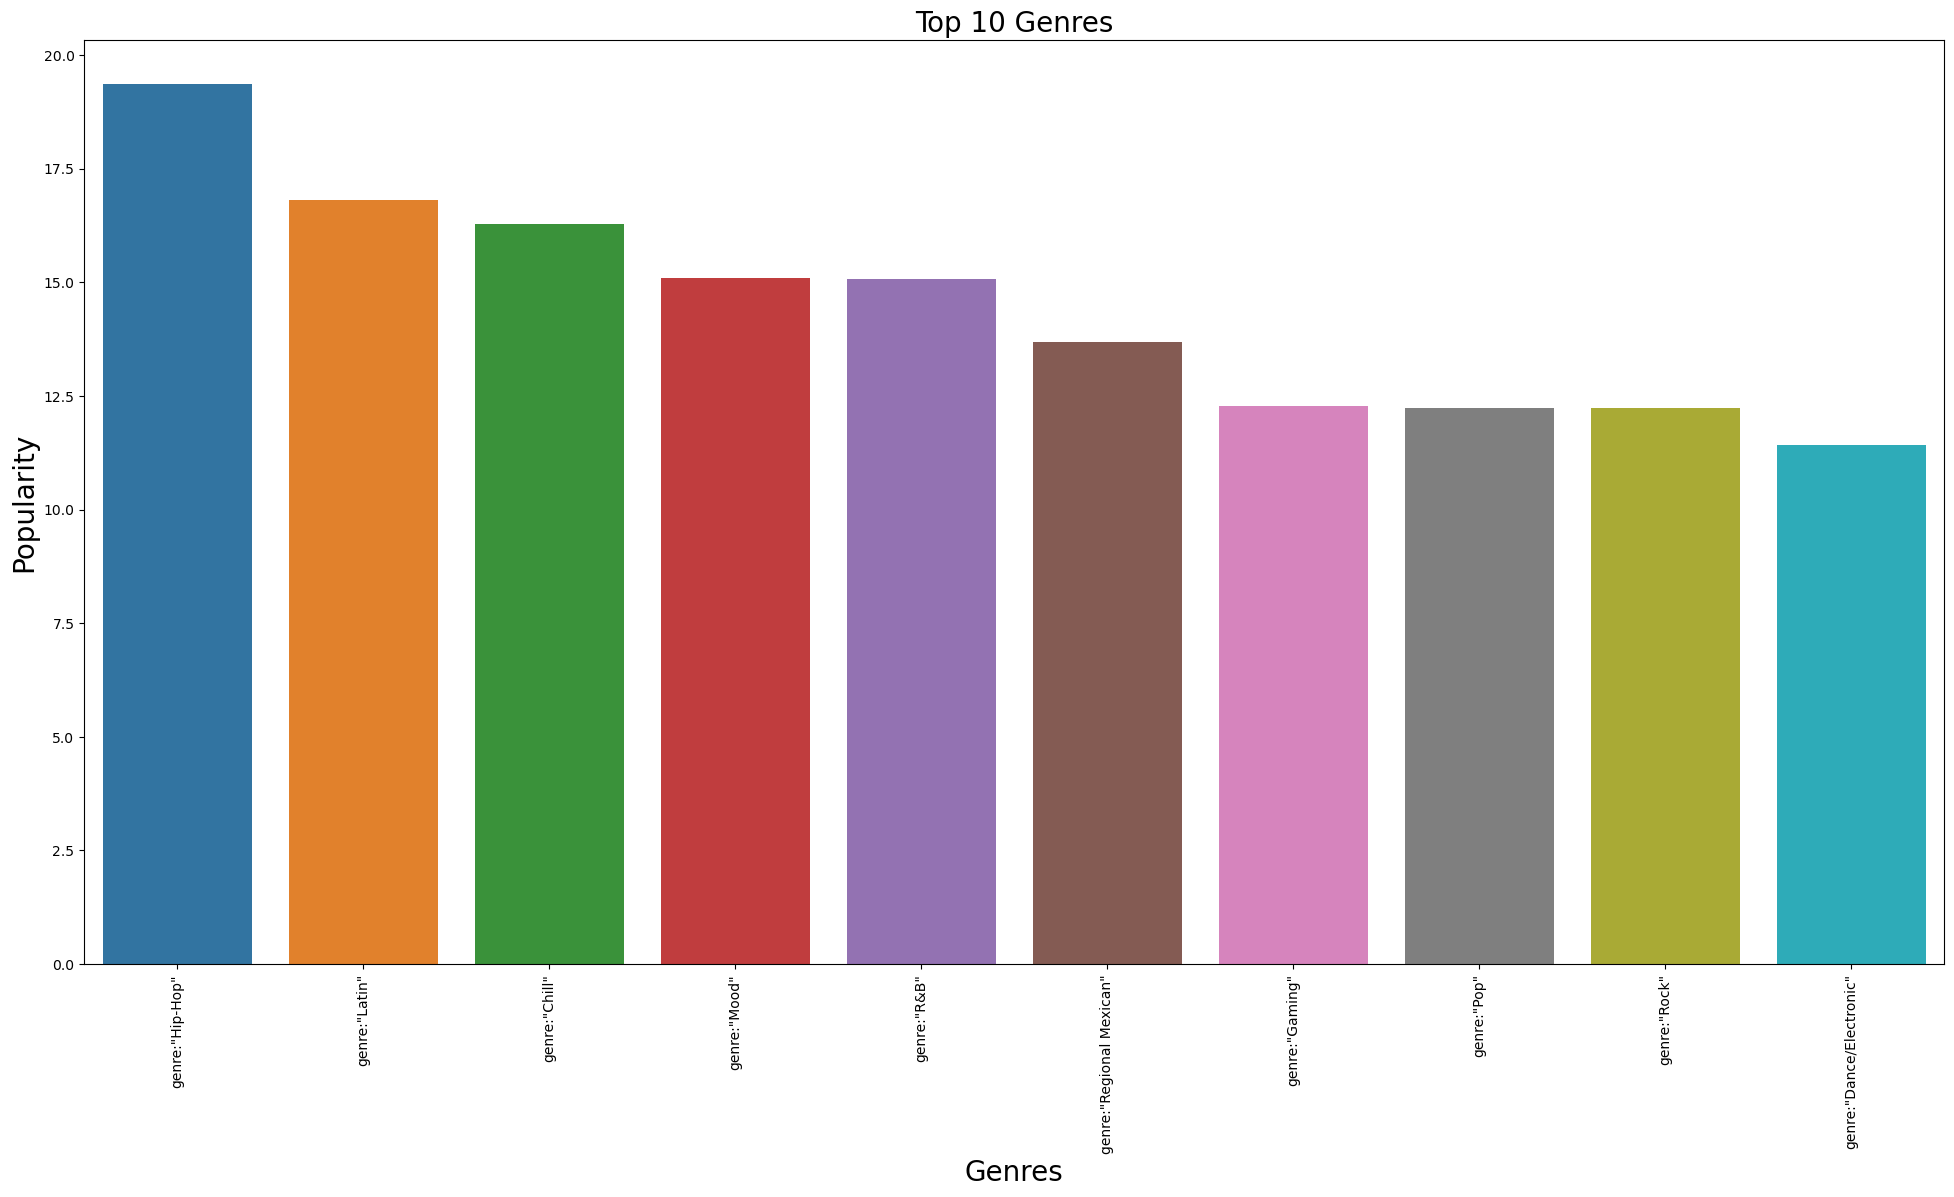

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average score for each genre
popularity_genre = uni_df.groupby('Genres')['Popularity'].mean().reset_index()

# Average scores obtained by sorting in descending order
popularity_genre = popularity_genre.sort_values('Popularity', ascending=False)

# Selection of top 10 data
popularity_top = popularity_genre.head(10)

# Setting the canvas size
plt.figure(figsize=(24,12))

# Plotting histograms, setting axes and values
sns.barplot(x='Genres', y='Popularity', data=popularity_top)
plt.xlabel('Genres', fontsize=20)
plt.ylabel('Popularity', fontsize=20)

# Setting the title
plt.title('Top 10 Genres',fontsize=20)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

plt.show()

## Answer: As you can see from the histogram the genre with the highest popularity is hip-hop

## Question 2: What kind of style has always been popular?

C:\Users\samuel\AppData\Local\Temp\ipykernel_21524\2808878928.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')


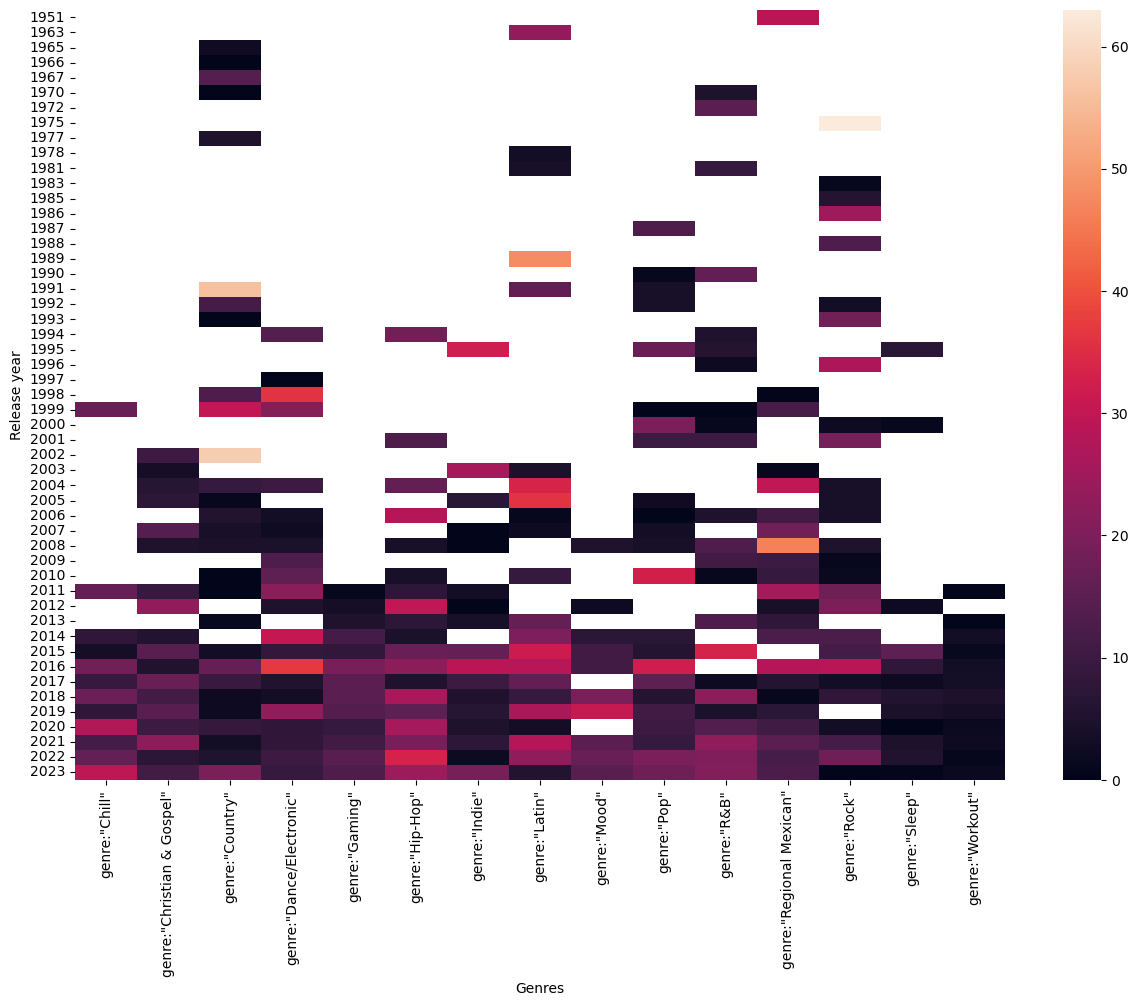

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


# Grouping of years to prevent overlap
final_df['Release year'] = final_df['Release year'].astype(int)
# Grouping by year and style and calculating popularity for each group
year_genre_popularity = final_df.groupby(['Release year', 'Genres'])['Popularity'].mean().reset_index()
# print(year_genre_popularity)
matrix = year_genre_popularity.pivot('Release year',  'Genres', 'Popularity')
plt.figure(figsize=(15,10))
sns.heatmap(matrix)
plt.show()

## Answer: Rock's genre is relatively more frequently popular

## Question 3: Which feature of audio is more likely to be popular?

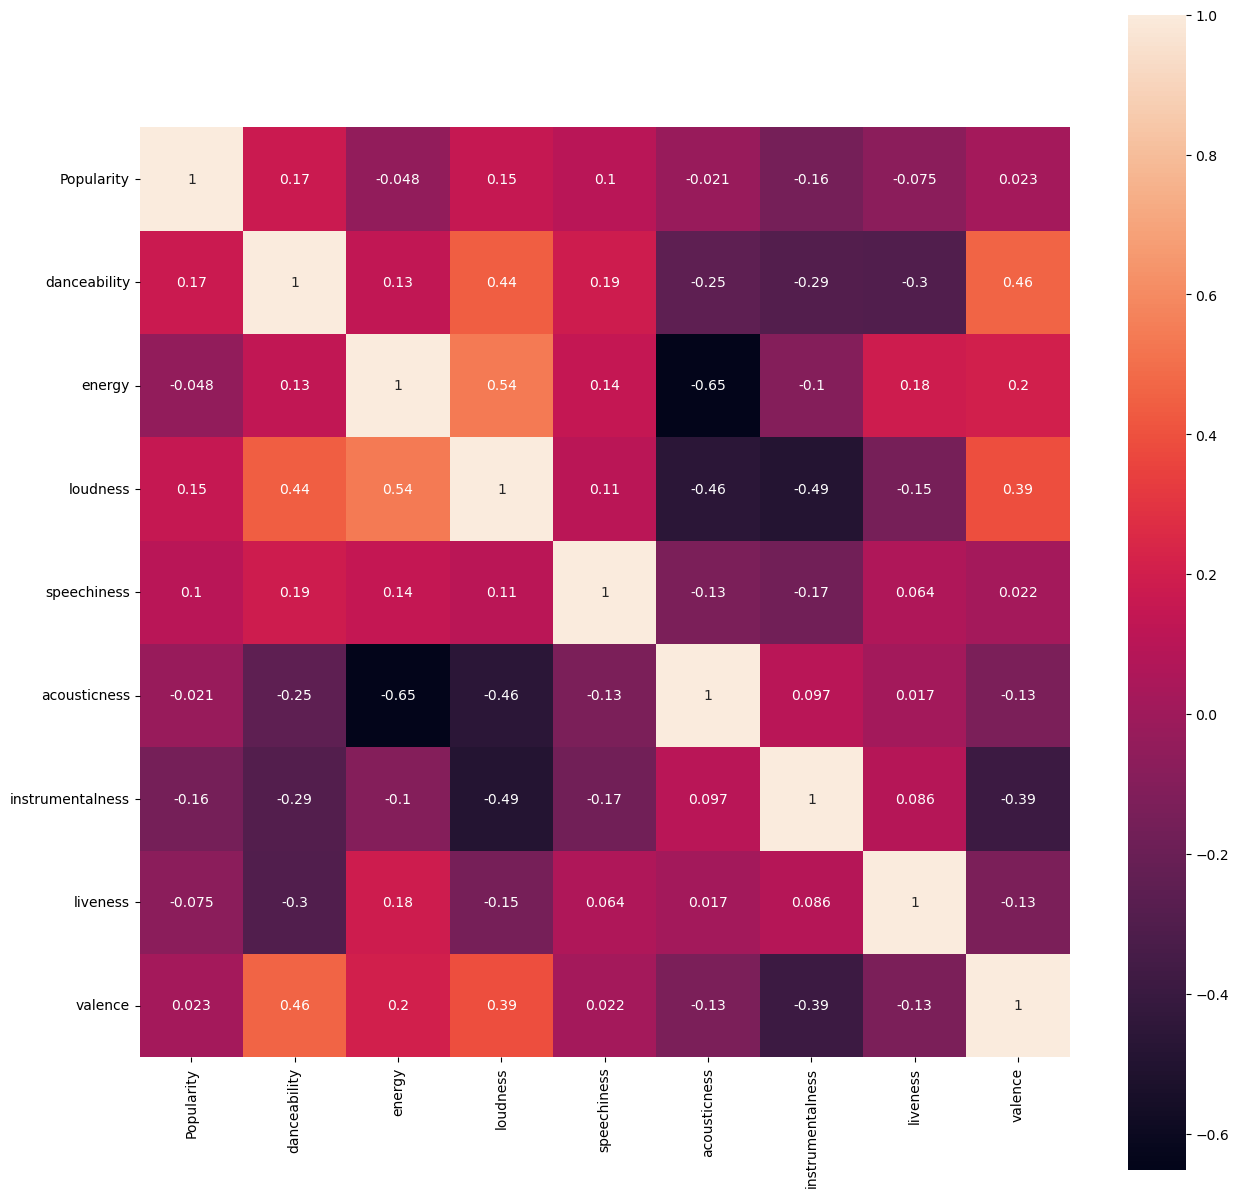

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Selection of features
features = ['Popularity', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# Formation of the feature matrix
matrix = final_df[features].corr()
# Define image size
plt.figure(figsize=(15,15))
# Heat mapping
sns.heatmap(matrix, annot=True, square=True)
plt.show()

## Answer: As can be seen from the heat map, danceability and loudness are positively correlated with popularity, proving that these two parameters have an effect in certain situations. Meanwhile, loudness and energy have the highest correlation, so combining these three factors can roughly deduce whether or not each place can be popular.

## Question 4: Choose three of your favorite features and recommend five pieces of music using the k-proximity algorithm.

In [28]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors


# Select the columns of audio features to be considered
features = ['loudness', 'energy', 'danceability']
X = final_df[features]

# 输入的音频特征
input_features = pd.DataFrame({
    'loudness': [-5],    
    'energy': [0.9],
    'danceability': [0.7]
})

# Calculating Similarity Using the Nearest Neighbor Algorithm
k = 5  # Select the top five most similar songs
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(X)

# Finding the most similar songs
distances, indices = knn.kneighbors(input_features)

# Five songs with the most similar output
recommended_songs = df.iloc[indices[0]]
print(recommended_songs)


                   Track ID                        Track name        Artist  \
59   5H2rqY1BFCJV3ExVFuBa2z          O vento noturno do verão    Nando Reis   
385  1bnXcP5WcygjKi9eQmNMHT  Dancing Box - Sleeparchive Remix  Modeselektor   
548  4VFFObZdgiHR78nuT9cCNp                 Waves: Relaxation  Water Sounds   
60   2jWcPEmSATAOMoKpEeXHzp                  Nikad nije kasno    Igor Delac   
485  0Hd01Olohf6LOvvrlZWmIH                         Dodo Gang      Aaron_RP   

     Popularity Release year                    Genres  
59           17         1995               genre:"Pop"  
385           3         2006  genre:"Dance/Electronic"  
548           0         2018             genre:"Sleep"  
60            4         2020               genre:"Pop"  
485           8         2022              genre:"Mood"  
